## Bank Customer Churn Prediction  (Guided by Analytics Vidhya)

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Loading Data

In [113]:
df = pd.read_csv('churn_prediction.csv')

In [114]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

# Filling Missing Values

In [115]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [116]:
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

In [117]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [118]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [119]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

In [120]:
df["city"].value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
334.0      930
1232.0     840
623.0      778
15.0       669
575.0      631
1525.0     375
905.0      345
491.0      312
1111.0     312
1494.0     289
649.0      281
1589.0     251
318.0      245
1084.0     240
61.0       237
531.0      227
656.0      197
904.0      187
630.0      166
1181.0     150
1271.0     150
1076.0     133
745.0      130
996.0      119
621.0      114
          ... 
1179.0       1
1421.0       1
973.0        1
847.0        1
1001.0       1
1279.0       1
1137.0       1
1245.0       1
1594.0       1
948.0        1
1026.0       1
1166.0       1
1545.0       1
808.0        1
503.0        1
1300.0       1
1605.0       1
824.0        1
607.0        1
1011.0       1
728.0        1
1207.0       1
566.0        1
972.0        1
1448.0       1
629.0        1
527.0        1
1212.0       1
530.0        1
70.0         1
Name: city, Length: 1604, dtype: int64

In [121]:
df['city'] = df['city'].fillna(1020)

In [122]:
df["days_since_last_transaction"].describe()

count    25159.000000
mean        69.997814
std         86.341098
min          0.000000
25%         11.000000
50%         30.000000
75%         95.000000
max        365.000000
Name: days_since_last_transaction, dtype: float64

In [123]:
df["days_since_last_transaction"].median()

30.0

In [124]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(30)

In [125]:
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [126]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [127]:
df_c = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [128]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

### Baseline Columns

In [129]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [130]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [131]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [132]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

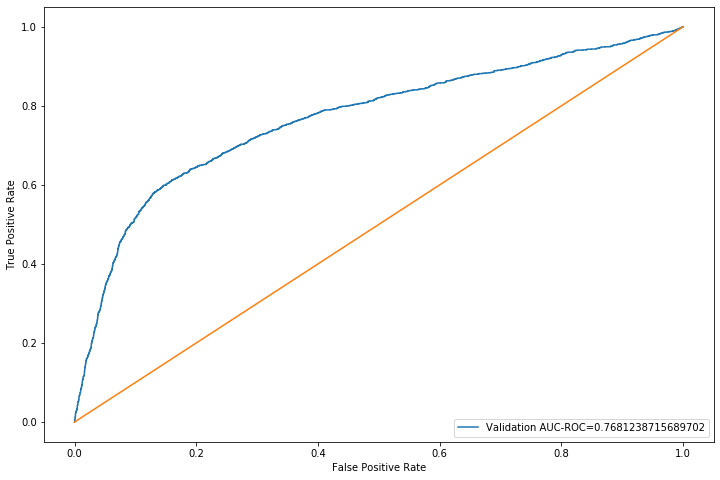

In [133]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [134]:
# Confusion Matrix
pred_val = model.predict(xtest)

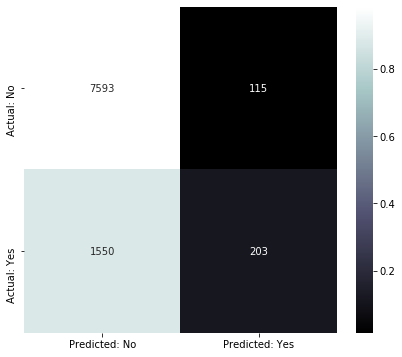

In [135]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [136]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

In [137]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [138]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.7790724488747302, Recall Score: 0.0732, Precision Score: 0.6638 

3 of kfold 5
ROC AUC Score: 0.7550891694186062, Recall Score: 0.1369, Precision Score: 0.6457 

4 of kfold 5
ROC AUC Score: 0.7582103868722617, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7624943261804835, Recall Score: 0.1122, Precision Score: 0.5756 


Now let us try using all columns available to check if we get significant improvement.

In [139]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7535009762614325, Recall Score: 0.1578, Precision Score: 0.6264 

2 of kfold 5
ROC AUC Score: 0.7283627581954579, Recall Score: 0.1112, Precision Score: 0.6324 

3 of kfold 5
ROC AUC Score: 0.7219612585025064, Recall Score: 0.1112, Precision Score: 0.5680 

4 of kfold 5
ROC AUC Score: 0.6841978781559593, Recall Score: 0.0713, Precision Score: 0.5474 

5 of kfold 5
ROC AUC Score: 0.7127367791782335, Recall Score: 0.1055, Precision Score: 0.5023 


There is some improvement in both ROC AUC Scores and Precision/Recall Scores.

In [140]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
rf_all_features = cv_score(RandomForestClassifier(n_estimators=100, max_depth=8))


1 of kfold 5
ROC AUC Score: 0.8211178707224334, Recall Score: 0.3546, Precision Score: 0.7285 

2 of kfold 5
ROC AUC Score: 0.8453318261227007, Recall Score: 0.3584, Precision Score: 0.7678 

3 of kfold 5
ROC AUC Score: 0.8351680396213506, Recall Score: 0.3593, Precision Score: 0.7426 

4 of kfold 5
ROC AUC Score: 0.8282266559330062, Recall Score: 0.3489, Precision Score: 0.7369 

5 of kfold 5
ROC AUC Score: 0.8244733009788572, Recall Score: 0.3555, Precision Score: 0.7305 


In [142]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'random_forest': rf_all_features})

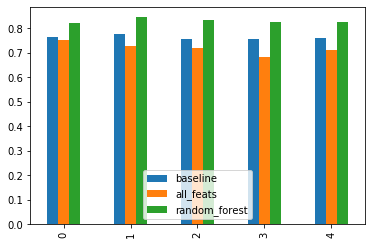

In [143]:
results_df.plot(y=["baseline", "all_feats", "random_forest"], kind="bar")